<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales
# Semana 7:
#### Nicolás Pereyra
---

## Consigna:
En el repositorio PDStestbench encontrará tres tipos de señales registradas:

- Electrocardiograma (ECG). En el archivo Ppg_TP4.mat encontrará un registro electrocardiográfico (ECG) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas más abajo.
- Pletismografía (PPG). El archivo PPG.csv contiene una señal registrada en reposo de un estudiante de la materia que ha donado su registro para esta actividad.
- Audio. Tres registros en los que el profesor pronuncia una frase, y otros dos en los que se silba una melodía muy conocida.

Los detalles de cómo acceder a dichos registros los pueden encontrar en lectura_sigs.py

Se pide:

1) Realizar la estimación de la densidad espectral de potencia (PSD) de cada señal mediante alguno de los métodos vistos en clase (Periodograma ventaneado, Welch, Blackman-Tukey).

2) Realice una estimación del ancho de banda de cada señal y presente los resultados en un tabla para facilitar la comparación.

Bonus:
- 💎 Proponga algún tipo de señal que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.

---

##Codigo
### Señalaes utilizadas:

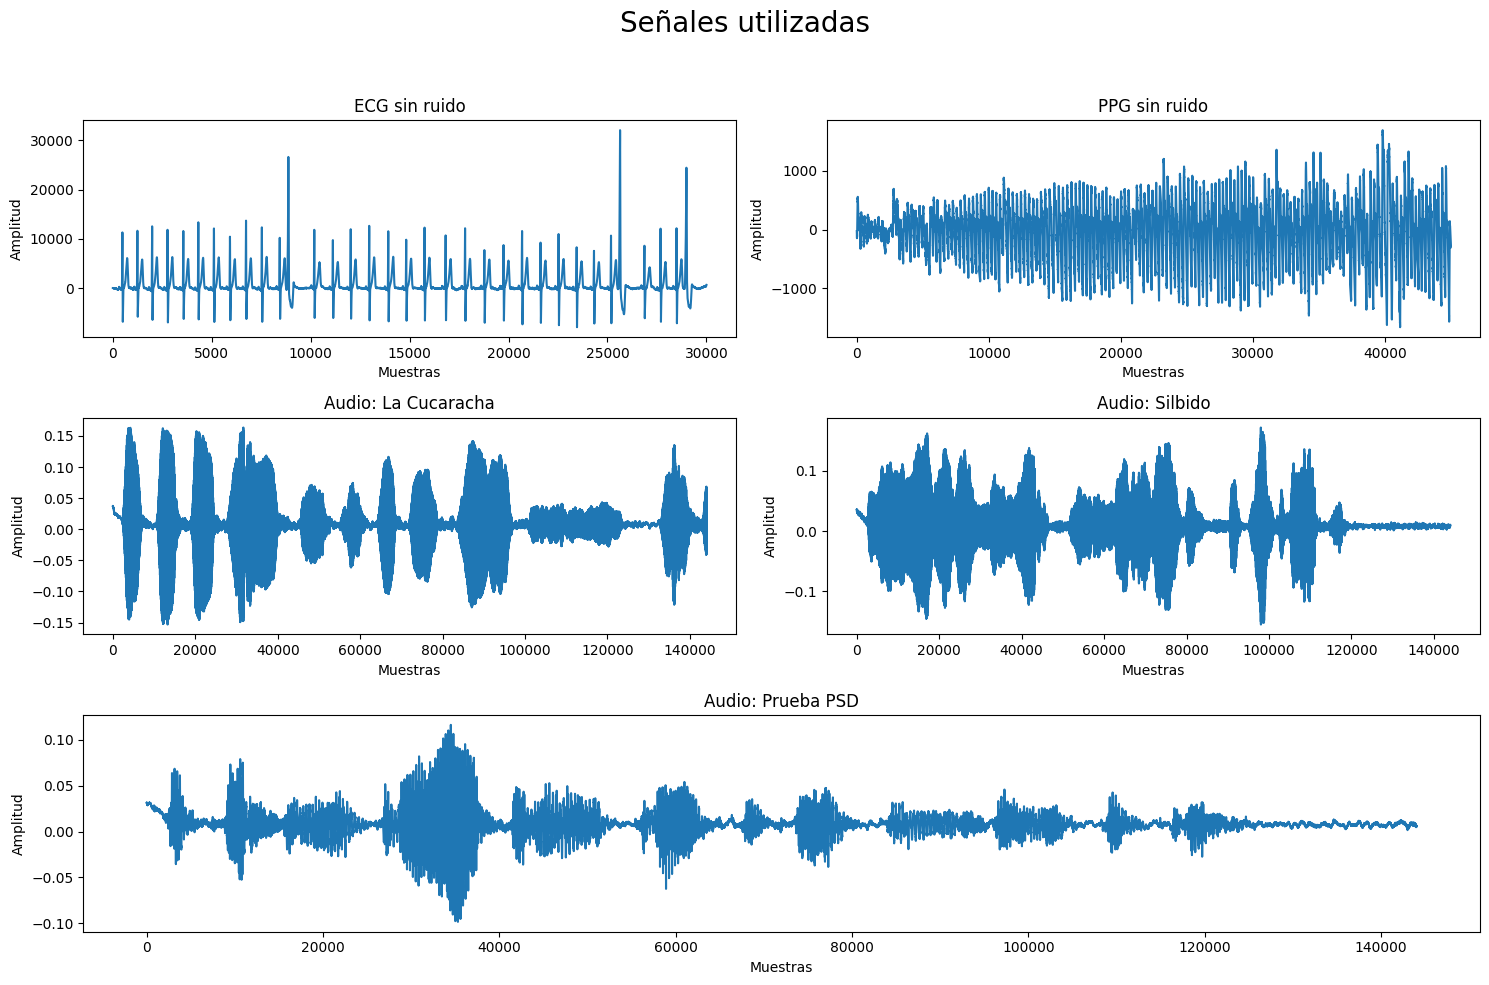

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import os
from matplotlib import gridspec

# Crear figura y layout de 3 filas x 2 columnas
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

# Ruta base
base_path = '../Mariano_lib/pdstestbench-master/'

######################################
# ECG sin ruido
######################################
fs_ecg = 1000
ecg_one_lead = np.load(os.path.join(base_path, 'ecg_sin_ruido.npy'))
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(ecg_one_lead)
ax0.set_title("ECG sin ruido")
ax0.set_xlabel("Muestras")
ax0.set_ylabel("Amplitud")

######################################
# PPG sin ruido
######################################
fs_ppg = 400
ppg = np.load(os.path.join(base_path, 'ppg_sin_ruido.npy'))
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(ppg)
ax1.set_title("PPG sin ruido")
ax1.set_xlabel("Muestras")
ax1.set_ylabel("Amplitud")

######################################
# Audio: La Cucaracha
######################################
fs_audio, wav_cuca = wav.read(os.path.join(base_path, 'la cucaracha.wav'))
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(wav_cuca)
ax2.set_title("Audio: La Cucaracha")
ax2.set_xlabel("Muestras")
ax2.set_ylabel("Amplitud")

######################################
# Audio: Silbido
######################################
fs_audio, wav_silbido = wav.read(os.path.join(base_path, 'silbido.wav'))
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(wav_silbido)
ax3.set_title("Audio: Silbido")
ax3.set_xlabel("Muestras")
ax3.set_ylabel("Amplitud")

######################################
# Audio: Prueba PSD (en toda la fila 3)
######################################
fs_psd, wav_psd = wav.read(os.path.join(base_path, 'prueba psd.wav'))
ax4 = fig.add_subplot(gs[2, :])  # Toda la fila 3
ax4.plot(wav_psd)
ax4.set_title("Audio: Prueba PSD")
ax4.set_xlabel("Muestras")
ax4.set_ylabel("Amplitud")

######################################
# Título general y ajustes
######################################
fig.suptitle("Señales utilizadas", fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

---
## Funciones:


In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

# Detecta la frecuencia pico
def detector_fp(fs, Y):
    i_max = np.argmax(Y)
    return i_max * fs / 2 / len(Y)

# Ancho de banda pasa bajos
def bandwidth_lp(fs, Y, percentage):
    total_power = np.sum(Y)
    power_bt = 0                        # Potencia acumulada
    i = 0
    while power_bt < total_power*percentage and i < len(Y):
        power_bt += Y[i]               # Acumula potencia
        i += 1
    #print(f"Power Lp: {power_bt:.0f}, Bw: {i* fs / 2 / len(Y)}")
    return i * fs / 2 / len(Y)

# Ancho de banda pasa banda
def bandwidth_bp(fs, Y, percentage):
    total_power = np.sum(Y)
    fp_index = np.argmax(Y)
    power_acc = Y[fp_index]
    
    left = fp_index - 1
    right = fp_index + 1

    min_index = fp_index
    max_index = fp_index

    while power_acc < total_power * percentage:
        # Chequea si se puede avanzar en ambos lados
        power_left = Y[left] if left >= 0 else -np.inf
        power_right = Y[right] if right < len(Y) else -np.inf

        # Elegir el lado con más potencia
        if power_left >= power_right:
            if left >= 0:
                power_acc += Y[left]
                min_index = left
                left -= 1
            else:
                if right < len(Y):
                    power_acc += Y[right]
                    max_index = right
                    right += 1
                else:
                    break  # Ambos límites alcanzados
        else:
            if right < len(Y):
                power_acc += Y[right]
                max_index = right
                right += 1
            else:
                if left >= 0:
                    power_acc += Y[left]
                    min_index = left
                    left -= 1
                else:
                    break  # Ambos límites alcanzados

    bw = (max_index - min_index+1) * fs / (2 * len(Y))  # Resolución en Hz
    #print(f"Power Pb: {power_acc:.0f}, BW: {bw:.2f} Hz")
    return bw

    return bw


# Ancho de banda pasa banda desde una frecuencia mínima
def bandwidth_bp2(fs, Y, percentage, f_min):
    total_power = np.sum(Y)

    f_min_index = int(f_min * len(Y) / (fs / 2))  # Índice de la frecuencia mínima
    i = f_min_index
    power_bt = 0                     # No sumes antes del while

    while power_bt < total_power * percentage and i < len(Y):
        power_bt += Y[i]
        i += 1

    bw = (i - f_min_index) * fs / (2 * len(Y))
    #print(f"Power Pb2: {power_bt:.0f}, BW: {bw:.2f} Hz")
    return bw

# Función principal
def analizar_ventanas(fs, signal, percentage=0.99, mode='lp', title="Análisis de Welch", f_min=0):
    windows = {
        'Flattop': 'r',
        'Blackman': 'g',
        'Hann': 'b'
    }

    N = len(signal)
    T = N / fs

    plt.figure(figsize=(10, 4))

    # En esta variable se acumula la potencia total medida por cada ventana
    power_t = 0

    for name, color in windows.items():
        f, Y = sig.welch(signal, fs, window=name.lower())

        # Pico
        fp = detector_fp(fs, Y)

        # Potencia estimada por la ventana (área bajo PSD)
        power = np.trapz(Y, f)
        power_t += power
        # Ancho de banda
        if mode == 'lp':
            bw = bandwidth_lp(fs, Y, percentage)
            bw_range = (0, bw)
        elif mode == 'bp':
            bw = bandwidth_bp(fs, Y, percentage)
            if  fp - bw/2 > 0:
                bw_range = (fp - bw/2, fp + bw/2)
            else:
                bw_range = (0, bw-fp)
        elif mode == 'bp2':
            bw = bandwidth_bp2(fs, Y, percentage, f_min)
            bw_range = (f_min, f_min + bw)
        else:
            raise ValueError("Modo inválido. Usa 'lp', 'bp' o 'bp2'.")

        # Etiqueta con datos
        label = f"{name} - fp={fp:.1f}Hz - bw={bw:.1f}Hz - P={power:.2e}"

        # Graficar PSD
        plt.semilogy(f, Y, color=color, label=label)

        # Marcar frecuencia pico
        plt.axvline(fp, color=color, linestyle='--')

        # Marcar ancho de banda
        plt.axvspan(*bw_range, color=color, alpha=0.2)

    power_t = power_t / len(windows)  # Promedio de potencia total
    power_t = power_t*percentage

    plt.title(f"{title} - Potencia concatenada {power_t:.2e}")
    plt.xlabel(f"Frecuencia [Hz] | N = {N} muestras | fs = {fs} Hz | T = {T:.2f} s")
    plt.ylabel("Densidad espectral [W/Hz]")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Señal ecg sin ruido:
A continuacion se podra observar la densidad de potencia espectral que nos termina dando el metodo de Welch para distintos tipos de ventanas en las cual podremos ver que al variar la ventana utilizada influye nuestra frecuencia pico y el ancho de banda obtenido.

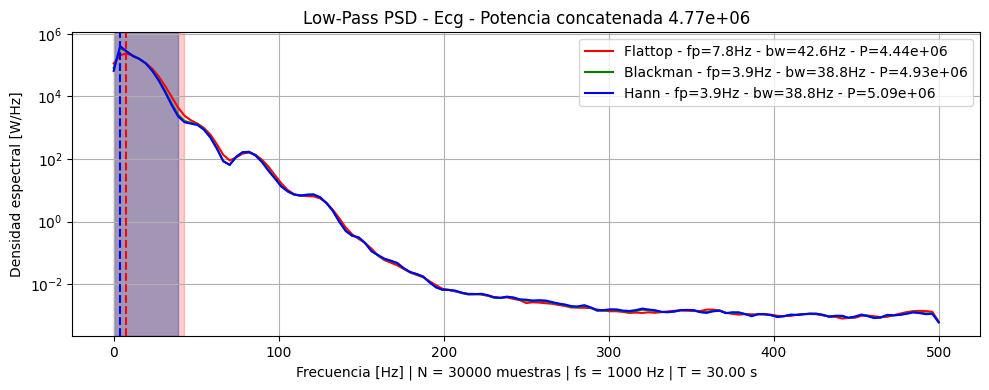

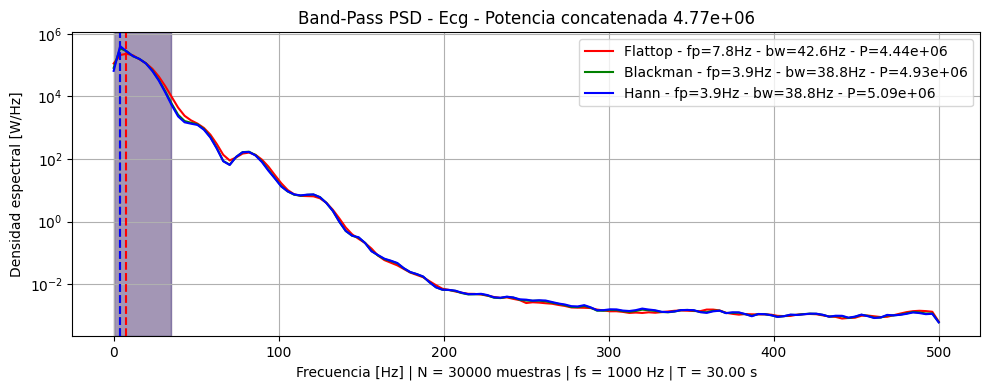

In [76]:
# Pasa bajos
analizar_ventanas(fs=fs_ecg, signal=ecg_one_lead, percentage=0.99, mode='lp', title="Low-Pass PSD - Ecg")

# Pasa banda
analizar_ventanas(fs=fs_ecg, signal=ecg_one_lead, percentage=0.99, mode='bp', title="Band-Pass PSD - Ecg")

---
### Señal PPG sin ruido:
Enn las siguientes señales se puede observar la densidad de potencia obtenida para una señal PPG utilizando distintos tipos de ventanas, como sucedio en el caso anteiror la enegia se encuentra cocentrada en un punto y muy proximo a los 0Hz por lo cual no se encuentra ninguna ventaja entre la utilizacion de un pasa banda y un pasa bajos.

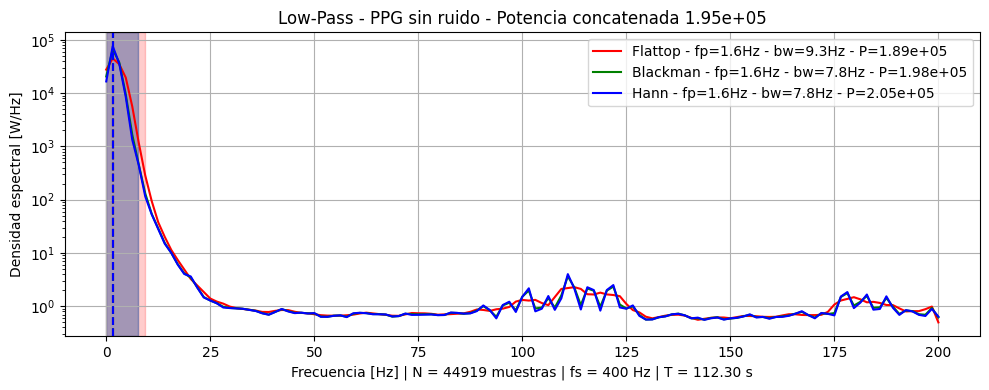

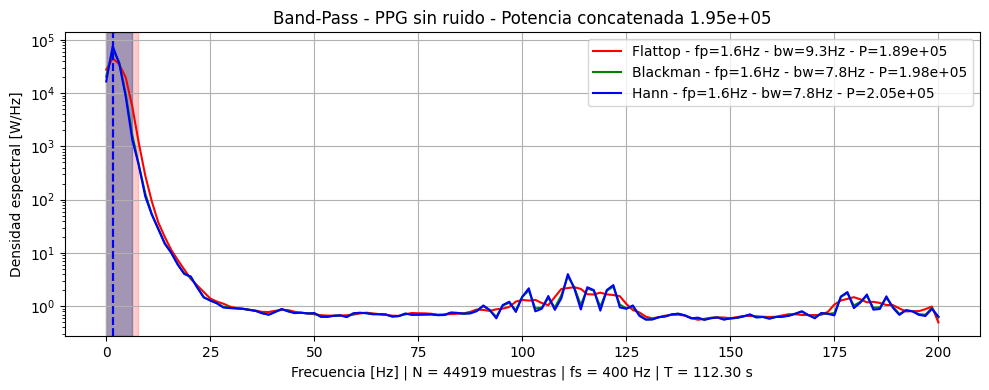

In [77]:
# Pasa bajos
analizar_ventanas(fs=fs_ppg, signal=ppg, percentage=0.99, mode='lp', title="Low-Pass - PPG sin ruido")

# Pasa banda
analizar_ventanas(fs=fs_ppg, signal=ppg, percentage=0.99, mode='bp', title="Band-Pass - PPG sin ruido")

---
### Audio:
En este caso se puede observar la densidad de potencia para uba señal de audio en la cual tiene un mayor sentido el de aplicarle un pasabanda para obtener un ancho de banda menor, en este caso utilizamos dos metodos para su calculo. El primero consta de obtener la frecuencia con mayor densidad de potencia y hacer crecer el ancho de banda de manera simetrica hasta concatenar la potencia pedida, por otro lado el segundo metodo consta de fijar una frecuencia minima y obtener la frecuencia maxima para la cual se concatene la potencia pedida.
El meotod que nos proporciono el menor ancho de banda fue el primer pasa banda y el cual nos proporciono un ancho de banda 22% meno que utilizando el metodo de pasa bajos. A su vez el segundo metodo de pasa banda mejoro los resultados del pasa bajos pero debido a la fijasion a ojo de una frecuencia minima no se logro un muy buen desempeño.

##### Cucharacha:

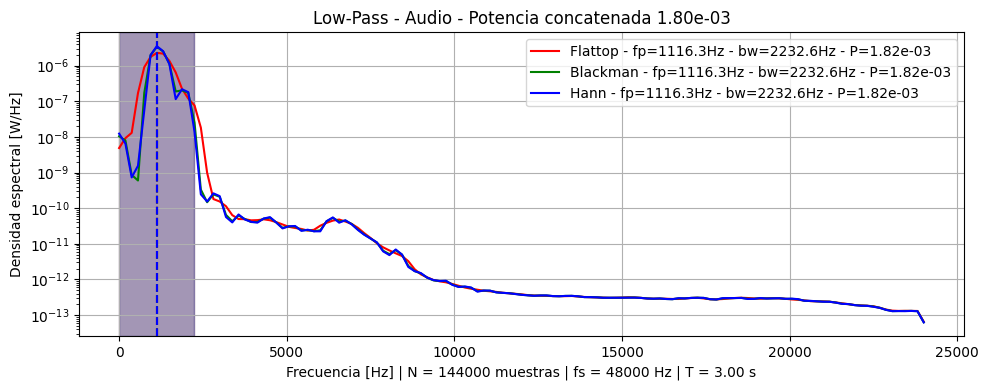

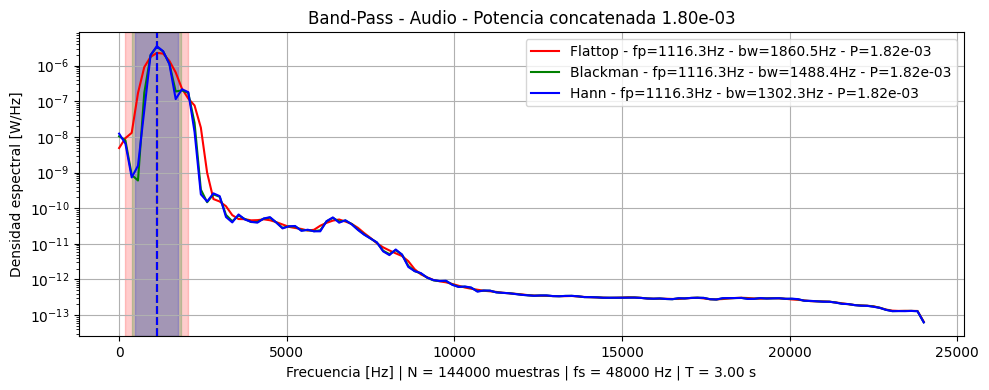

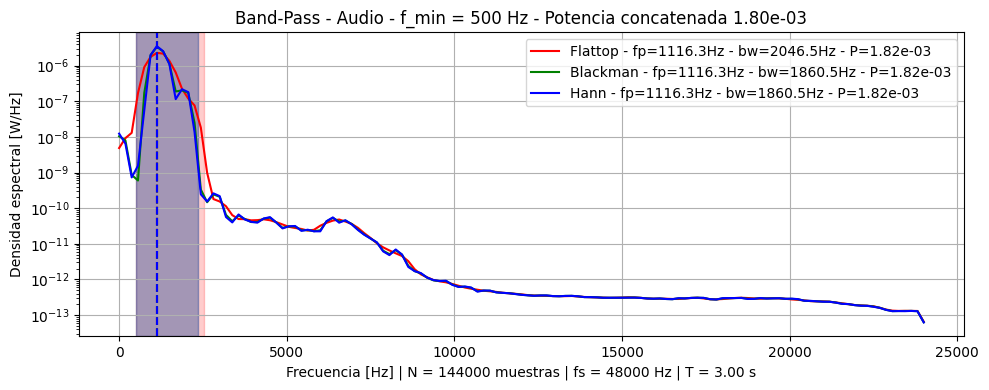

In [ ]:
# Pasa bajos
analizar_ventanas(fs=fs_audio, signal=wav_cuca, percentage=0.99, mode='lp', title="Low-Pass - Audio")

# Pasa bandas
analizar_ventanas(fs=fs_audio, signal=wav_cuca, percentage=0.99, mode='bp', title="Band-Pass - Audio")

# Pasa banda desde frecuencia mínima
analizar_ventanas(fs=fs_audio, signal=wav_cuca, percentage=0.99, mode='bp2', f_min=500, title="Band-Pass - Audio - f_min = 500 Hz")

##### Silbido:

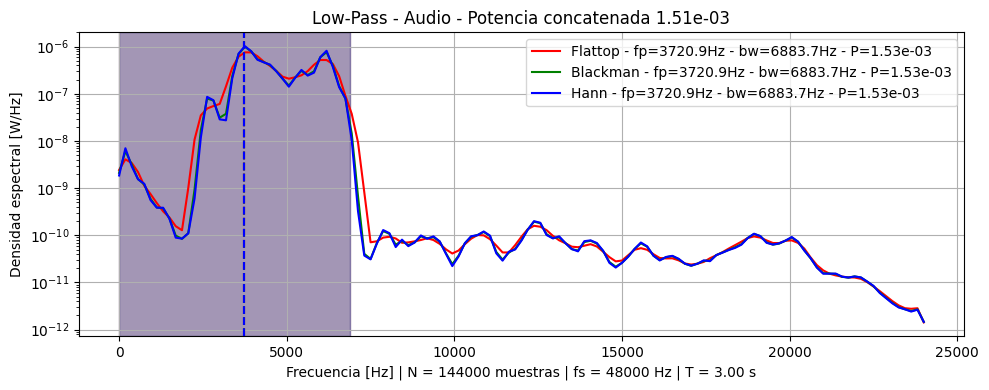

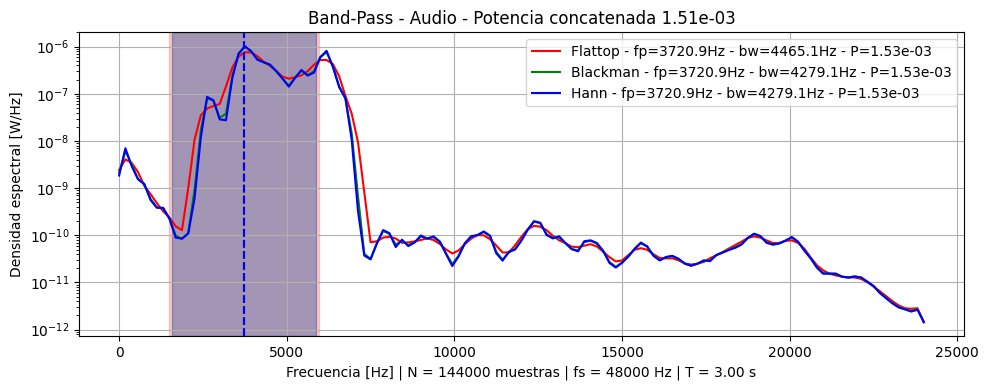

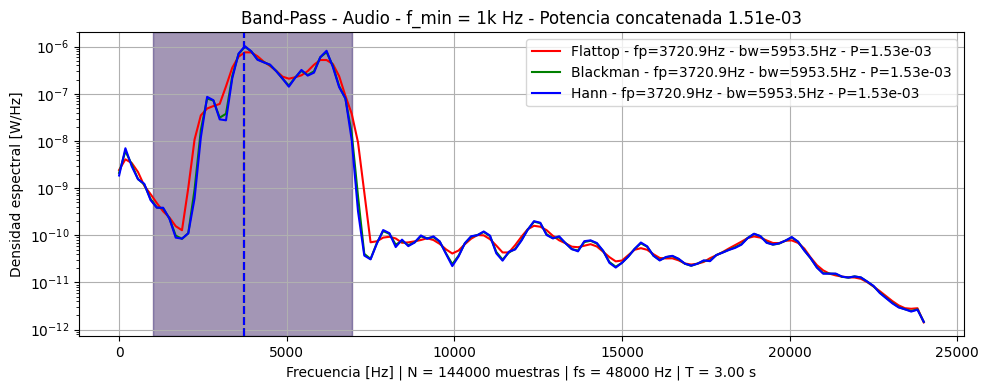

In [88]:
# Pasa bajos
analizar_ventanas(fs=fs_audio, signal=wav_silbido, percentage=0.99, mode='lp', title="Low-Pass - Audio")

# Pasa banda
analizar_ventanas(fs=fs_audio, signal=wav_silbido, percentage=0.99, mode='bp', title="Band-Pass - Audio")

# Pasa banda desde frecuencia mínima
analizar_ventanas(fs=fs_audio, signal=wav_silbido, percentage=0.99, mode='bp2', f_min=1000, title="Band-Pass - Audio - f_min = 1k Hz")

##### PSD:

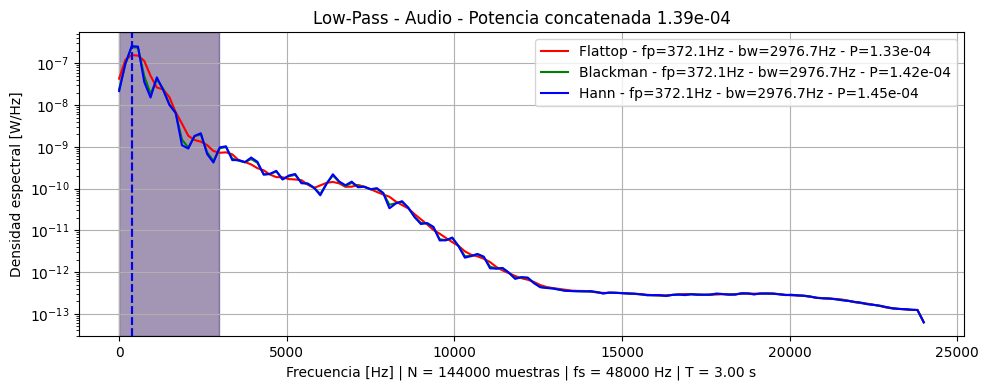

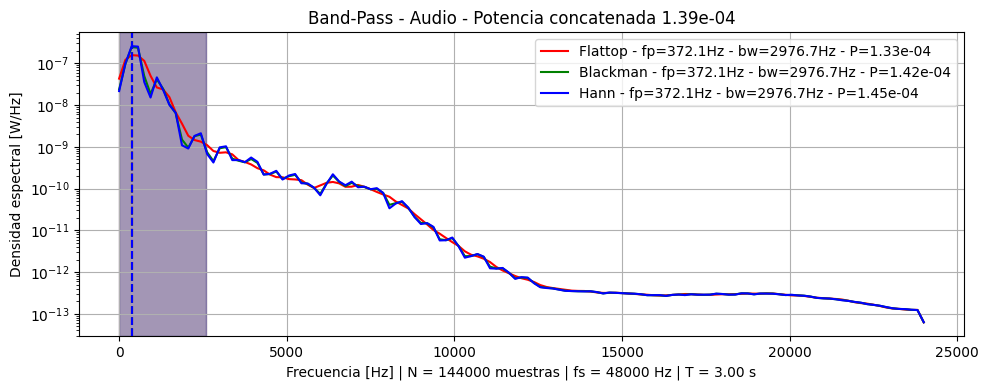

In [86]:
# Pasa bajos
analizar_ventanas(fs=fs_audio, signal=wav_psd, percentage=0.99, mode='lp', title="Low-Pass - Audio")

# Pasa banda
analizar_ventanas(fs=fs_audio, signal=wav_psd, percentage=0.99, mode='bp', title="Band-Pass - Audio")

---
### Resultados:
A continuacion se brindaran una tabla de resultados en la cual se podra observar el ancho de banda necesaria para obtener el 99% de la energia de la señal para distitas ventanas y metododos apra acotar la señal.

<div align="center">
<table style="border-collapse: collapse; text-align: center; font-family: sans-serif; font-size: 14px; color: #000000; background-color: #f0f0f0;">

  <!-- Cabecera principal -->
  <tr style="background-color: #d0d0d0;">
    <th rowspan="2" style="padding: 8px;"></th>
    <th colspan="3">ECG</th>
    <th colspan="3">PPG</th>
    <th colspan="3">Cucaracha</th>
    <th colspan="3">Silbido</th>
    <th colspan="3">PSD</th>
  </tr>

  <!-- Ventanas -->
  <tr style="background-color: #e0e0e0;">
    <td>Hann</td>
    <td>Blackman</td>
    <td>Flattop</td>
    <td>Hann</td>
    <td>Blackman</td>
    <td>Flattop</td>
    <td>Hann</td>
    <td>Blackman</td>
    <td>Flattop</td>
    <td>Hann</td>
    <td>Blackman</td>
    <td>Flattop</td>
    <td>Hann</td>
    <td>Blackman</td>
    <td>Flattop</td>
  </tr>

  <!-- fp -->
  <tr>
    <td style="text-align: left; padding-left: 10px;">fp [Hz]</td>
    <td>3.9</td><td>3.9</td><td>7.8</td>
    <td>1.6</td><td>1.6</td><td>1.6</td>
    <td>1166</td><td>1166</td><td>1166</td>
    <td>3720</td><td>3720</td><td>3720</td>
    <td>372</td><td>372</td><td>372</td>
  </tr>
  
  <!-- BW Lp-->
  <tr>
    <td style="text-align: left; padding-left: 10px;">BW Lp [Hz]</td>
    <td>38.8</td><td>38.8</td><td>42.6</td>
    <td>7.8</td><td>7.8</td><td>9.3</td>
    <td>2232</td><td>2232</td><td>2232</td>
    <td>6883</td><td>6883</td><td>6883</td>
    <td>2976</td><td>2976</td><td>2976</td>
  </tr>

  <!-- BW Pb1 -->
  <tr>
    <td style="text-align: left; padding-left: 10px;">BW PB1 [Hz]</td>
    <td>38.8</td><td>38.8</td><td>42.6</td>
    <td>7.8</td><td>7.8</td><td>9.3</td>
    <td>1302</td><td>1488</td><td>1860</td>
    <td>4279</td><td>4279</td><td>4465</td>
    <td>2976</td><td>2976</td><td>2976</td>
  </tr>

  <!-- BW Pb2 -->
  <tr>
    <td style="text-align: left; padding-left: 10px;">PB2 [Hz]</td>
    <td>X</td><td>X</td>X<td>X</td>
    <td>X</td><td>X</td><td>X</td>
    <td>1860</td><td>1860</td><td>2046</td>
    <td>5953</td><td>5953</td><td>5953</td>
    <td>X</td><td>X</td><td>X</td>
  </tr>

</table>
</div>